<a href="https://colab.research.google.com/github/ykitaguchi77/Streamlit_Colab_Tutorial/blob/main/section_5/MobileNet_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像認識アプリ
MobileNetV3を用いた画像認識

## ●ライブラリのインストール
Streamlit、およびアプリの動作の確認に使用する「ngrok」をインストールします。

In [15]:
!pip install streamlit==1.7.0 --quiet
!pip install pyngrok==4.1.1 --quiet

Streamlit、およびngrokをインポートしておきます。  
エラーが発生する場合は、「ランタイム」→「ランタイムを再起動」によりランタイムを再起動し、再びコードセルを上から順に実行しましょう。

In [16]:
import streamlit as st
from pyngrok import ngrok

## ●「モデル」を扱うファイル
画像認識の訓練済みモデルを読み込み、予測を行うコードを「model.py」に書き込みます。  

In [52]:
#imagenet_classes.txtを作成
!pip install shap --quiet
import shap
import json

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

with open("imagenet_classes.txt", "w") as outfile:
    outfile.write("\n".join(str(item) for item in class_names))
     

In [53]:
net = timm.create_model(model_name= "mobilenetv3_large_100", pretrained=True)  # 訓練済みのモデルを読み込み
torch.save(net.state_dict(), 'mobilenetv3.pth')

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth)
2022-12-12 10:24:04.562 INFO    timm.models.helpers: Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth)


動作確認

In [18]:
# download sample image
!wget https://www.lamborghini.com/sites/it-en/files/DAM/lamborghini/facelift_2019/model_detail/menu/09_09/menu_asterion.png -O car.png --quiet

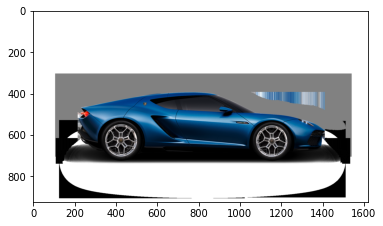

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[('sports_car', 0.6113967299461365),
 ('car_wheel', 0.08522693812847137),
 ('convertible', 0.07662561535835266),
 ('racer', 0.0529690757393837),
 ('beach_wagon', 0.0090536093339324)]

In [56]:
import torch
from torchvision import models, transforms
from PIL import Image
!pip install timm --quiet
import timm
import matplotlib.pyplot as plt

with open("imagenet_classes.txt") as f:  # ラベルの読み込み
    classes = [line.strip() for line in f.readlines()]

def predict(img):
    # 以下の設定はこちらを参考に設定: https://pytorch.org/hub/pytorch_vision_resnet/
    transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                        )
                                    ])

    net = timm.create_model(model_name= "mobilenetv3_large_100", pretrained=False)  # 訓練済みのモデルを読み込み
    net.load_state_dict(torch.load(
        "mobilenetv3.pth", map_location=torch.device("cpu")
        ))
    # モデルへの入力
    img = transform(img)
    x = torch.unsqueeze(img, 0)  # バッチ対応

    # 予測
    net.eval()
    y = net(x)

    # 結果を返す
    y_prob = torch.nn.functional.softmax(torch.squeeze(y))  # 確率で表す
    sorted_prob, sorted_indices = torch.sort(y_prob, descending=True)  # 降順にソート
    return [(classes[idx], prob.item()) for idx, prob in zip(sorted_indices, sorted_prob)]


##############
## Interference ##
##############

#show image
img = Image.open("/content/car.png").convert('RGB')
plt.imshow(img)
plt.show()

#predict image
predict(img)[:5]

In [64]:
%%writefile model.py
# 以下を「model.py」に書き込み
import torch
from torchvision import models, transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt

with open("imagenet_classes.txt") as f:  # ラベルの読み込み
    classes = [line.strip() for line in f.readlines()]

def predict(img):
    # 以下の設定はこちらを参考に設定: https://pytorch.org/hub/pytorch_vision_resnet/
    transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                        )
                                    ])

    net = timm.create_model(model_name= "mobilenetv3_large_100", pretrained=False)  # 訓練済みのモデルを読み込み
    net.load_state_dict(torch.load(
        "mobilenetv3.pth", map_location=torch.device("cpu")
        ))
    # モデルへの入力
    img = transform(img)
    x = torch.unsqueeze(img, 0)  # バッチ対応

    # 予測
    net.eval()
    y = net(x)

    # 結果を返す
    y_prob = torch.nn.functional.softmax(torch.squeeze(y))  # 確率で表す
    sorted_prob, sorted_indices = torch.sort(y_prob, descending=True)  # 降順にソート
    return [(classes[idx], prob.item()) for idx, prob in zip(sorted_indices, sorted_prob)]


Overwriting model.py


## ●アプリのコード
画像認識アプリのコードを、「app.py」に書き込みます。  
ローカルからアップロード、もしくはWebカメラで撮影した画像ファイルに、何が映っているのかを判定します。  
なお、Webカメラはngrokが発行したURLではセキュリティ上動作しないので、今回は動作を確認できません。

In [59]:
%%writefile app.py
# 以下を「app.py」に書き込み
import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from model import predict

st.set_option("deprecation.showfileUploaderEncoding", False)

st.sidebar.title("画像認識アプリ")
st.sidebar.write("ResNetを使って何の画像かを判定します。")

st.sidebar.write("")

img_source = st.sidebar.radio("画像のソースを選択してください。",
                              ("画像をアップロード", "カメラで撮影"))
if img_source == "画像をアップロード":
    img_file = st.sidebar.file_uploader("画像を選択してください。", type=["png", "jpg"])
elif img_source == "カメラで撮影":
    img_file = st.camera_input("カメラで撮影")

if img_file is not None:
    with st.spinner("推定中..."):
        img = Image.open(img_file).convert('RGB')
        st.image(img, caption="対象の画像", width=480)
        st.write("")

        # 予測
        results = predict(img)

        # 結果の表示
        st.subheader("判定結果")
        n_top = 5  # 確率が高い順に5位まで返す
        for result in results[:n_top]:
            st.write(str(round(result[1]*100, 2)) + "%の確率で" + result[0] + "です。")

        # 円グラフの表示
        pie_labels = [result[0] for result in results[:n_top]]
        pie_labels.append("others")
        pie_probs = [result[1] for result in results[:n_top]]
        pie_probs.append(sum([result[1] for result in results[n_top:]]))
        fig, ax = plt.subplots()
        wedgeprops={"width":0.3, "edgecolor":"white"}
        textprops = {"fontsize":6}
        ax.pie(pie_probs, labels=pie_labels, counterclock=False, startangle=90,
               textprops=textprops, autopct="%.2f", wedgeprops=wedgeprops)  # 円グラフ
        st.pyplot(fig)

Overwriting app.py


## ●Authtokenの設定
ngrokで接続するために必要な「Authtoken」を設定します。  
以下のコードの、  
`!ngrok authtoken YourAuthtoken`  
における  
`YourAuthtoken`の箇所を、自分のAuthtokenに置き換えます。  
Authtokenは、ngrokのサイトに登録すれば取得することができます。  
https://ngrok.com/


In [60]:
!ngrok authtoken YourAuthToken

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## ●アプリの起動と動作確認
streamlitの`run`コマンドでアプリを起動します。


In [65]:
!streamlit run app.py &>/dev/null&  # 「&>/dev/null&」により、出力を非表示にしてバックグランドジョブとして実行

ngrokのプロセスを終了した上で、新たにポートを指定して接続します。  
接続の結果、urlを取得できます。  
ngrokの無料プランでは同時に1つのプロセスしか動かせないので、エラーが発生した場合は「ランタイム」→「セッションの管理」で不要なGoogle Colabのセッションを修了しましょう。  

In [66]:
ngrok.kill()  # プロセスの修了
url = ngrok.connect(port="8501")  # 接続

INFO:pyngrok.process:Killing ngrok process: 1308
2022-12-12 10:29:40.090 INFO    pyngrok.process: Killing ngrok process: 1308
INFO:pyngrok.process:ngrok process starting: 1338
2022-12-12 10:29:40.167 INFO    pyngrok.process: ngrok process starting: 1338
INFO:pyngrok.process:t=2022-12-12T10:29:40+0000 lvl=info msg="no configuration paths supplied"

2022-12-12 10:29:40.208 INFO    pyngrok.process: t=2022-12-12T10:29:40+0000 lvl=info msg="no configuration paths supplied"

INFO:pyngrok.process:t=2022-12-12T10:29:40+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2022-12-12 10:29:40.220 INFO    pyngrok.process: t=2022-12-12T10:29:40+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

INFO:pyngrok.process:t=2022-12-12T10:29:40+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2022-12-12 10:29:40.232 INFO    pyngrok.process: t=2022-12-12T10:29:40+0000 lvl=info msg="open config file" 

urlを表示し、リンク先でアプリが動作することを確認します。

In [67]:
print(url)

http://6635-35-221-230-185.ngrok.io


## ●requirements.txtの作成
Streamlit Cloudのサーバー上でアプリを動かすために、「requirements.txt」を作成する必要があります。  
このファイルでは、必要なライブラリのバージョンを指定します。  


まずは、アプリでimportするライブラリのバージョンを確認します。

In [33]:
import streamlit
import torch
import torchvision
import PIL
import matplotlib
import timm


print("streamlit==" + streamlit.__version__)
print("torch==" + torch.__version__)
print("torchvision==" + torchvision.__version__)
print("Pillow==" + PIL.__version__)
print("matplotlib==" + matplotlib.__version__)
print("timm==" + timm.__version__)


streamlit==1.7.0
torch==1.13.0+cu116
torchvision==0.14.0+cu116
Pillow==7.1.2
matplotlib==3.2.2
timm==0.6.12


上記を参考に、各ライブラリの望ましいバージョンを記述しrequirements.txtに保存します。

In [35]:
with open("requirements.txt", "w") as w:
    w.write("streamlit==1.8.1\n")  # Streamlit Cloud上で動作が確認できたバージョン
    w.write("torch==1.10.0\n")  # Cuda対応は要らないのでcu111は記述しない
    w.write("torchvision==0.11.1\n")  # Cuda対応は要らないのでcu111は記述しない
    w.write("Pillow==7.1.2\n")
    w.write("matplotlib==3.2.2\n")
    w.write("timm==0.6.12\n")

以下の作成されたファイルをダウンロードして、GitHubのレポジトリにアップしましょう。
* app.py
* model.py
* requirements.txt

In [68]:
#必要ファイルを圧縮してダウンロード
import zipfile
list_files = ["app.py", "model.py", "requirements.txt", "mobilenetv3.pth"]

with zipfile.ZipFile('streamlit.zip', 'w') as zipF:
    for file in list_files:
        zipF.write(file, compress_type=zipfile.ZIP_DEFLATED)

print(f'The {len(list_files)} files has been compressed')

The three files has been compressed


In [69]:
from google.colab import files
files.download('streamlit.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>